Saved pairs table: /Users/jeongin/oopt/result/image/image_rating_pairs.csv (rows=84)
Saved grouped grid: /Users/jeongin/oopt/result/image/image_ratings_grid_grouped.png
Saved grouped grid: /Users/jeongin/oopt/result/image/image_ratings_grid_grouped.png


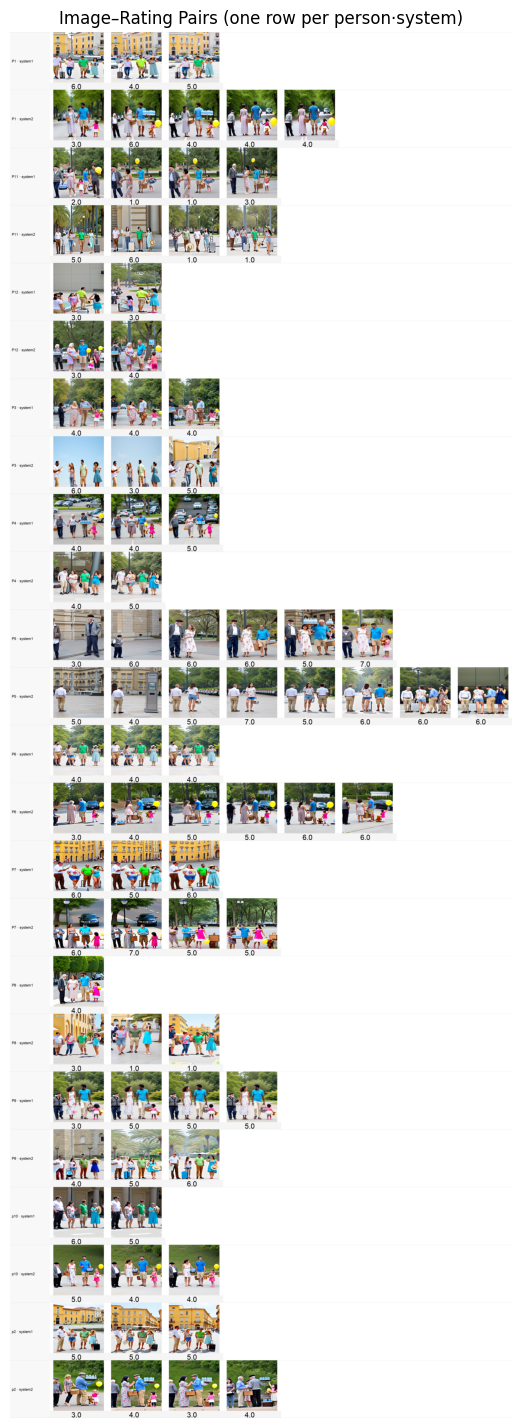

In [16]:
"""
Pair images with their next rating and draw a grid figure.

Usage:
  - Put this script next to your logs or adjust BASE_DIR / LOG_GLOB.
  - Make sure images are reachable (absolute path, or searchable by basename under SEARCH_ROOT).
  - pip install pandas pillow matplotlib

Outputs:
  - image_rating_pairs.csv  (paired table)
  - image_ratings_grid.png  (grid figure)
"""

import json
import os
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional
from zoneinfo import ZoneInfo

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# ====== Config ======
BASE_DIR = Path("./log")  # where logs live (e.g., ./log)
LOG_GLOB = "P*.log"  # match your log files (e.g., P2.log, P3.log ...)
SEARCH_ROOT = Path(
    "."
)  # root folder to find images if paths are relative or only basenames
TZ = "Asia/Seoul"
GRID_COLS = 4  # columns in the figure grid
TILE_W, TILE_H = 320, 320  # each cell size
OUT_CSV = Path("result/image/image_rating_pairs.csv")
OUT_IMG = Path("result/image/image_ratings_grid.png")

# If your JSON uses other keys, add here:
EVENT_IMAGE_DONE = "image_generation_completed"
EVENT_RATING_DONE = "image_quality_modal.rating_submitted"
EVENT_SYSTEM_COMPLETED = "system_completed"  # <-- system_type은 여기서만 추출

DETAIL_KEYS_IMAGE = ("image_path", "image", "path", "filepath", "file")
DETAIL_KEYS_RATING = (
    "rating",
    "score",
    "value",
    "selected",
    "selected_value",
    "selected_score",
)
DETAIL_KEYS_SYSTEM = ("system", "system_type", "system_id")


# ====== Helpers ======
def _parse_ts(ts: str, tz: str = TZ) -> datetime:
    """Parse ISO-like timestamps into tz-aware datetime."""
    if not ts:
        raise ValueError("Empty timestamp")
    ts = ts.replace("Z", "+00:00")
    try:
        dt = datetime.fromisoformat(ts)
    except Exception:
        # relaxed fallback: "YYYY-mm-dd HH:MM:SS"
        dt = datetime.strptime(ts, "%Y-%m-%d %H:%M:%S")
    return dt.astimezone(ZoneInfo(tz))


def _iter_log_events(path: Path):
    """Yield JSON events from lines that contain a JSON object."""
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            i = line.find("{")
            if i == -1:
                continue
            try:
                rec = json.loads(line[i:])
            except json.JSONDecodeError:
                continue
            if isinstance(rec, dict) and "event" in rec:
                yield rec


def _get_person(rec: Dict[str, Any], fallback: str) -> str:
    return str(rec.get("user_id") or rec.get("participant") or fallback)


# === 1) system 추출 유틸은 그대로(우선순위만 system_type 먼저) ===
def _get_system(details: Dict[str, Any]) -> Optional[str]:
    for k in ("system_type", "system", "system_id"):
        if k in details:
            return str(details[k])
    return None


def _get_rating(details: Dict[str, Any]) -> Optional[float]:
    for k in DETAIL_KEYS_RATING:
        if k in details:
            try:
                return float(details[k])
            except (TypeError, ValueError):
                pass
    return None


def _get_image_path(details: Dict[str, Any]) -> Optional[str]:
    for k in DETAIL_KEYS_IMAGE:
        v = details.get(k)
        if isinstance(v, str) and v.strip():
            return v.strip()
    return None


def _resolve_image_path(p: str, search_root: Path) -> Optional[Path]:
    """
    Resolve image path:
      - if absolute and exists -> ok
      - if relative under search_root -> ok
      - otherwise search by basename under search_root
    """
    candidate = Path(p)
    if candidate.is_absolute() and candidate.exists():
        return candidate

    candidate2 = (search_root / p).resolve()
    if candidate2.exists():
        return candidate2

    base = Path(p).name
    for root, _, files in os.walk(search_root):
        if base in files:
            return Path(root) / base
    return None

# 폰트 경로(환경에 맞게 바꿔도 됨)
FONT_CANDIDATES = [
    "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
    "/usr/share/fonts/trtf/DejaVuSans.ttf",
    "/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf",
    "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf",
    "DejaVuSans.ttf", "NotoSans-Regular.ttf", "Arial.ttf",
]

def _load_font(size: int) -> ImageFont.ImageFont:
    for p in FONT_CANDIDATES:
        try:
            return ImageFont.truetype(p, size=size)
        except Exception:
            pass
    # 최후의 수단(크기 안 먹을 수 있음)
    print("loading default...")
    return ImageFont.load_default()


# ====== Core: pair extraction ======
# 2) 페어링: 이미지 쪽에는 system을 저장하지 않고,
#    rating이 들어올 때 rating의 system_type을 사용해 저장
# === 2) 페어링 함수: 블록(시스템 구간) 단위로 commit ===
def extract_image_rating_pairs(log_paths: List[Path]) -> pd.DataFrame:
    """
    각 person별로:
      - image_generation_completed → pending 큐에 저장
      - rating_submitted → pending에서 하나 꺼내 '블록 버퍼'에 임시 저장(아직 system 없음)
      - system_completed → 방금까지의 블록 버퍼를 이 이벤트의 system_type으로 채워 최종 rows에 커밋
    """
    rows_final: List[Dict[str, Any]] = []

    for log_path in log_paths:
        fallback_person = log_path.stem.lower()  # e.g., "p2"
        pending_imgs: Dict[str, List[Dict[str, Any]]] = {}  # person → [이미지 대기열]
        block_pairs: Dict[
            str, List[Dict[str, Any]]
        ] = {}  # person → [이 블록에서 쌓인 (img, rating) 페어(아직 system 없음)]

        for rec in _iter_log_events(log_path):
            ev = rec.get("event")
            ts = _parse_ts(rec.get("timestamp") or rec.get("time") or "")
            details = rec.get("details") or {}
            person = _get_person(rec, fallback_person)

            # 1) 이미지 완료 → 대기열에 push
            if ev == EVENT_IMAGE_DONE:
                img_path_str = _get_image_path(details)
                if not img_path_str:
                    continue
                resolved = _resolve_image_path(img_path_str, SEARCH_ROOT)
                pending_imgs.setdefault(person, []).append(
                    {
                        "img_timestamp": ts,
                        "image_path_raw": img_path_str,
                        "image_path": str(resolved) if resolved else None,
                    }
                )

            # 2) 평점 제출 → 대기열에서 하나 꺼내 현재 블록 버퍼에 저장(시스템은 아직 모름)
            elif ev == EVENT_RATING_DONE:
                rating = _get_rating(details)
                if rating is None:
                    continue
                q = pending_imgs.get(person, [])
                if not q:
                    # 대응 이미지가 없으면 스킵
                    continue
                img_rec = q.pop(0)
                block_pairs.setdefault(person, []).append(
                    {
                        "person": person,
                        "system_type": None,  # 나중에 채움
                        "system": None,  # 호환용
                        "image_timestamp": img_rec["img_timestamp"],
                        "image_path_raw": img_rec["image_path_raw"],
                        "image_path": img_rec["image_path"],
                        "rating_timestamp": ts,
                        "rating": float(rating),
                    }
                )

            # 3) 시스템 종료 → 이번 블록의 페어들에 system_type을 채워 넣고 최종 커밋
            elif ev == EVENT_SYSTEM_COMPLETED:
                sys_type = _get_system(details) or "unknown"
                blk = block_pairs.get(person, [])
                if blk:
                    for row in blk:
                        row["system_type"] = sys_type
                        row["system"] = sys_type  # (이전 코드와의 호환)
                    rows_final.extend(blk)
                    block_pairs[person] = []  # 새 블록 시작 준비

        # 파일 끝났는데 마지막 블록이 아직 커밋 안 된 경우(= system_completed 누락)
        # → system_type을 모르면 'unknown'으로 커밋
        for person, blk in block_pairs.items():
            if blk:
                for row in blk:
                    if not row["system_type"]:
                        row["system_type"] = "unknown"
                        row["system"] = "unknown"
                rows_final.extend(blk)

    if not rows_final:
        return pd.DataFrame(
            columns=[
                "person",
                "system_type",
                "system",
                "image_timestamp",
                "image_path_raw",
                "image_path",
                "rating_timestamp",
                "rating",
            ]
        )

    df = (
        pd.DataFrame(rows_final)
        .sort_values(["person", "image_timestamp", "rating_timestamp"])
        .reset_index(drop=True)
    )
    return df


# ====== Grid drawing ======
def draw_image_rating_grid(
    df: pd.DataFrame,
    out_path: Path = OUT_IMG,
    columns: int = GRID_COLS,
    tile_w: int = TILE_W,
    tile_h: int = TILE_H,
) -> Path:
    """
    Make a single image grid. Each cell shows the image and a caption with rating, person, system.
    """
    if df.empty:
        img = Image.new("RGB", (640, 200), (245, 245, 245))
        d = ImageDraw.Draw(img)
        font = _load_font(28)  # 안내문구 폰트 크기 증가
        d.text((20, 80), "No (image, rating) pairs found.", fill=(0, 0, 0), font=font)
        img.save(out_path)
        return out_path

    n = len(df)
    rows = (n + columns - 1) // columns
    W = columns * tile_w
    H = rows * tile_h
    canvas = Image.new("RGB", (W, H), (255, 255, 255))
    draw = ImageDraw.Draw(canvas)
    font_caption = _load_font(50)  # 캡션 폰트 크기 증가

    for idx, row in df.iterrows():
        r, c = divmod(idx, columns)
        x0, y0 = c * tile_w, r * tile_h

        # load tile
        tile = None
        img_path = row.get("image_path")
        try_paths = [img_path] if img_path else []
        if not img_path and isinstance(row.get("image_path_raw"), str):
            try_paths.append(str((SEARCH_ROOT / row["image_path_raw"]).resolve()))

        for p in try_paths:
            if p and Path(p).exists():
                try:
                    tile = Image.open(p).convert("RGB")
                    break
                except Exception:
                    tile = None

        CAPTION_H = 40
        # fallback placeholder
        if tile is None:
            tile = Image.new("RGB", (tile_w, tile_h - CAPTION_H), (235, 235, 235))
            d2 = ImageDraw.Draw(tile)
            name = Path(row.get("image_path_raw") or "not_found").name
            d2.multiline_text(
                (10, 10),
                f"Not found\n{name}",
                fill=(80, 80, 80),
                font=font_caption,
                spacing=4,
            )

        # resize to fit (keep aspect)
        w, h = tile.size
        target_h = tile_h - CAPTION_H
        scale = min(tile_w / w, target_h / h) if w > 0 and h > 0 else 1.0
        new_w, new_h = max(1, int(w * scale)), max(1, int(h * scale))
        tile_resized = tile.resize((new_w, new_h))

        # paste centered
        px = x0 + (tile_w - new_w) // 2
        py = y0 + (target_h - new_h) // 2
        canvas.paste(tile_resized, (px, py))

        # caption area
        bar_y0 = y0 + target_h
        draw.rectangle([x0, bar_y0, x0 + tile_w, y0 + tile_h], fill=(245, 245, 245))

        rating = row.get("rating")
        person = str(row.get("person"))
        sys_type = str(row.get("system_type") or row.get("system") or "unknown")
        caption = f"★ {rating if pd.notna(rating) else 'NA'}  |  {person} · {sys_type}"
        draw.text((x0 + 8, bar_y0 + 10), caption, fill=(0, 0, 0), font=font_caption)

    canvas.save(out_path)
    return out_path


# ====== NEW: grouped one-row-per-(person, system_type) grid ======
def draw_grouped_rows_grid(
    df: pd.DataFrame,
    out_path: Path,
    tile_w: int = 320,
    tile_h: int = 320,
    left_gutter: int = 220,  # 왼쪽 라벨 영역 너비
) -> Path:
    """
    각 (person, system_type) 그룹을 '한 줄'로 그린다.
    캔버스 너비는 '그룹 중 가장 많은 이미지 수 × tile_w + left_gutter'.
    라벨(예: "p2 · system1")은 왼쪽 gutter에 표시, 타일 캡션은 별점만 표시.
    """
    if df.empty:
        img = Image.new("RGB", (640, 200), (245, 245, 245))
        d = ImageDraw.Draw(img)
        d.text(
            (20, 80),
            "No (image, rating) pairs found.",
            fill=(0, 0, 0),
            font=_load_font(36),  # 안내문구 폰트 크기 증가
        )
        img.save(out_path)
        return out_path

    # 정렬: person → system_type → image_timestamp
    df_sorted = df.sort_values(["person", "system_type", "image_timestamp"]).copy()

    # 그룹화
    groups = []
    for (person, sys_type), g in df_sorted.groupby(
        ["person", "system_type"], sort=False
    ):
        groups.append(
            {
                "label": f"{person} · {sys_type}",
                "rows": g.reset_index(drop=True),
            }
        )

    max_cols = max(len(g["rows"]) for g in groups) if groups else 0
    if max_cols == 0:
        max_cols = 1  # 안전장치

    W = left_gutter + max_cols * tile_w
    H = len(groups) * tile_h

    canvas = Image.new("RGB", (W, H), (255, 255, 255))
    draw = ImageDraw.Draw(canvas)
    font_label = _load_font(20)  # 라벨 폰트 크기 증가
    font_caption = _load_font(40)  # 캡션 폰트 크기 증가

    # 행 분리선 색
    line_color = (230, 230, 230)

    for r, grp in enumerate(groups):
        y0 = r * tile_h

        # 1) 왼쪽 라벨 영역
        draw.rectangle([0, y0, left_gutter, y0 + tile_h], fill=(248, 248, 248))
        # 라벨 텍스트 수직 중앙
        label_text = grp["label"]
        tw, th = draw.textlength(label_text, font=font_label), font_label.size
        draw.text(
            (10, y0 + (tile_h - th) // 2), label_text, fill=(0, 0, 0), font=font_label
        )

        # 행 구분선
        draw.line([0, y0, W, y0], fill=line_color, width=1)

        # 2) 타일들
        CAPTION_H = 40
        rows = grp["rows"]
        for c in range(len(rows)):
            row = rows.iloc[c]
            x0 = left_gutter + c * tile_w

            # 이미지 로드
            tile = None
            img_path = row.get("image_path")
            try_paths = [img_path] if img_path else []
            if not img_path and isinstance(row.get("image_path_raw"), str):
                try_paths.append(str((SEARCH_ROOT / row["image_path_raw"]).resolve()))

            for pth in try_paths:
                if pth and Path(pth).exists():
                    try:
                        tile = Image.open(pth).convert("RGB")
                        break
                    except Exception:
                        tile = None

            # placeholder
            if tile is None:
                tile = Image.new("RGB", (tile_w, tile_h - CAPTION_H), (235, 235, 235))
                d2 = ImageDraw.Draw(tile)
                name = Path(row.get("image_path_raw") or "not_found").name
                d2.multiline_text(
                    (10, 10),
                    f"Not found\n{name}",
                    fill=(80, 80, 80),
                    font=font_caption,
                    spacing=4,
                )

            # 리사이즈 & 붙이기
            w, h = tile.size
            target_h = tile_h - CAPTION_H
            scale = min(tile_w / w, target_h / h) if w > 0 and h > 0 else 1.0
            new_w, new_h = max(1, int(w * scale)), max(1, int(h * scale))
            tile_resized = tile.resize((new_w, new_h))
            px = x0 + (tile_w - new_w) // 2
            py = y0 + (target_h - new_h) // 2
            canvas.paste(tile_resized, (px, py))

            # 캡션(별점만)
            bar_y0 = y0 + target_h
            draw.rectangle([x0, bar_y0, x0 + tile_w, y0 + tile_h], fill=(245, 245, 245))
            rating = row.get("rating")
            caption = f"{rating if pd.notna(rating) else 'NA'}"
            draw.text((x0 + 120, bar_y0), caption, fill=(0, 0, 0), font=font_caption)

    # 마지막 행 하단선
    draw.line([0, H - 1, W, H - 1], fill=line_color, width=1)

    canvas.save(out_path, quality=95)
    return out_path


if __name__ == "__main__":
    log_files = sorted(BASE_DIR.glob(LOG_GLOB))
    pairs_df = extract_image_rating_pairs(
        log_files
    )  # (system_type은 system_completed에서 채워지는 버전)

    pairs_df.to_csv(OUT_CSV, index=False)
    print(f"Saved pairs table: {OUT_CSV.resolve()} (rows={len(pairs_df)})")

    out_img = draw_grouped_rows_grid(
        pairs_df,
        out_path=Path("result/image/image_ratings_grid_grouped.png"),
        tile_w=TILE_W,
        tile_h=TILE_H,
        left_gutter=220,
    )
    print(f"Saved grouped grid: {out_img.resolve()}")

    # (선택) 미리보기
    img = Image.open(out_img)
    plt.figure(figsize=(min(22, img.width), min(18, img.height)))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Image–Rating Pairs (one row per person·system)")
    plt.show()


In [17]:
"""
Compute per-system stats and plot using image_rating_pairs.csv.

- Uses the maximum rating per (person, system) to avoid duplicate bias.
- Saves:
    top_ratings_by_person_system.csv   # person×system 최고 평점 테이블
    system_stats.csv                   # system별 n/mean/std/sem/ci95
    system_means_bar.png               # 평균+95% CI 막대그래프
"""

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

IN_CSV = Path("result/image/image_rating_pairs.csv")
TOP_CSV = Path("result/image/top_ratings_by_person_system.csv")
STATS_CSV = Path("result/image/system_stats.csv")
PLOT_PNG = Path("result/image/system_means_bar.png")


def load_pairs(csv_path: Path) -> pd.DataFrame:
    """CSV 로드 + 컬럼 정리 (system_type 우선), rating 숫자화."""
    df = pd.read_csv(csv_path)
    if "system_type" in df.columns:
        df["system"] = df["system_type"]
    elif "system" not in df.columns:
        raise ValueError("CSV must contain either 'system_type' or 'system'.")
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df = df.dropna(subset=["person", "system", "rating"])
    return df


def top_ratings_by_person_system(df: pd.DataFrame) -> pd.DataFrame:
    """person×system별 최고 평점만 남김."""
    top = (
        df.groupby(["person", "system"], as_index=False)["rating"]
        .max()
        .rename(columns={"rating": "max_rating"})
        .sort_values(["person", "system"])
        .reset_index(drop=True)
    )
    return top


def system_stats_from_top(top: pd.DataFrame) -> pd.DataFrame:
    """top_ratings를 기반으로 system별 통계."""
    g = top.groupby("system")["max_rating"]
    stats = pd.DataFrame(
        {
            "n": g.count(),
            "mean": g.mean(),
            "std": g.std(ddof=1),
            "sem": g.sem(ddof=1),
        }
    )
    # 95% CI (정규 근사, 작은 표본이면 참고용)
    stats["ci95"] = 1.96 * stats["sem"]
    stats = stats.reset_index().sort_values("system").reset_index(drop=True)
    return stats


def plot_system_means(stats: pd.DataFrame, out_png: Path):
    """시스템별 평균(막대) + 95% CI 에러바를 하나의 Figure로 저장."""
    if stats.empty:
        print("No stats to plot.")
        return
    x = np.arange(len(stats))
    means = stats["mean"].to_numpy()
    ci = stats["ci95"].to_numpy()

    plt.figure(figsize=(8, 5))
    plt.bar(x, means)  # 색 지정 안 함 (기본값)
    plt.errorbar(x, means, yerr=ci, fmt="none", capsize=5)  # 에러바
    plt.xticks(x, stats["system"], rotation=0)
    plt.ylabel("Average Rating")
    plt.title("Average (Max per Person×System) Rating by System\n(with 95% CI)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.close()
    print(f"Saved plot: {out_png.resolve()}")


def main():
    df = load_pairs(IN_CSV)
    top = top_ratings_by_person_system(df)
    top.to_csv(TOP_CSV, index=False)
    print(f"Saved: {TOP_CSV.resolve()} (rows={len(top)})")

    stats = system_stats_from_top(top)
    stats.to_csv(STATS_CSV, index=False)
    print(f"Saved: {STATS_CSV.resolve()}")
    print(stats)

    plot_system_means(stats, PLOT_PNG)


if __name__ == "__main__":
    main()
    main()


Saved: /Users/jeongin/oopt/result/image/top_ratings_by_person_system.csv (rows=24)
Saved: /Users/jeongin/oopt/result/image/system_stats.csv
    system   n      mean       std       sem      ci95
0  system1  12  4.833333  1.267304  0.365839  0.717045
1  system2  12  5.416667  1.240112  0.357990  0.701660
Saved plot: /Users/jeongin/oopt/result/image/system_means_bar.png
Saved: /Users/jeongin/oopt/result/image/top_ratings_by_person_system.csv (rows=24)
Saved: /Users/jeongin/oopt/result/image/system_stats.csv
    system   n      mean       std       sem      ci95
0  system1  12  4.833333  1.267304  0.365839  0.717045
1  system2  12  5.416667  1.240112  0.357990  0.701660
Saved plot: /Users/jeongin/oopt/result/image/system_means_bar.png
Saved plot: /Users/jeongin/oopt/result/image/system_means_bar.png


In [2]:
import pandas as pd
from pathlib import Path
import shutil

# Load top ratings and participant info
top_ratings = pd.read_csv("result/image/image_rating_pairs.csv")
info = pd.read_csv("participant_info.csv")

# Melt participant_info to long format: (participant, system, target_image)
info_long = pd.DataFrame([
    {"person": row["participants"], "system": "system1", "target_image": row["System 1"]} for _, row in info.iterrows()
    ] + [
    {"person": row["participants"], "system": "system2", "target_image": row["System 2"]} for _, row in info.iterrows()
])
# Merge to get target image for each (person, system)
merged = pd.merge(top_ratings, info_long, how="left", left_on=["person", "system"], right_on=["person", "system"])
# Output directory
output_dir = Path("result/image/top_images_by_system_target")
output_dir.mkdir(parents=True, exist_ok=True)

# Group and save images
for (system, target), group in merged.groupby(["system", "target_image"]):
    group_dir = output_dir / f"{system}" / f"{target}"
    group_dir.mkdir(parents=True, exist_ok=True)
    for _, row in group.iterrows():
        img_path = row.get("image_path")
        if pd.notna(img_path) and Path(img_path).exists():
            dest = group_dir / f"{row['person']}_top.png"
            shutil.copy(img_path, dest)

print(f"Saved top images grouped by system and target to {output_dir}")

Saved top images grouped by system and target to result/image/top_images_by_system_target
